# Exploration of Missed Tackles

## Why Missed Tackles

Tackling is a critical part of every football play. The one goal of the defense is to reach the ball carrier and bring them to the ground. This goal has two parts. First the defender must arrive in the same location as the ball carrier, but once they are there it is still imperitive to complete the tackle. Sometimes the defender is unable to bring the ball carrier to the ground and this is considered a missed tackle. This exploration considers the parts of the tackle and looks for indicators of missed tackles prior to contact.

## Metrics

### Parts of a Tackle

Tackles can be broken down to investigate different parts. First, is the need to reach the same point. Projecting the players direction to calculate the contact point can provide information about the possible contact. Such as the contact angle, the distance to contact, and the momentum of each player at contact. The momentum of each player can be further analyzed by determining the momentum in the x and y directions. Since the offense is attempting to advance the ball the ball carrier's momentum in the positive x direction will provide the most value and the defenders momentum in the negative x direction will be attempting to counter the positive x momentum of the ball carrier.

### Calculation of Metrics

All metrics were calculated based on a single frame from the tracking data. The calculations assume the frame represents a constant state that will continue until the defender and ball carrier make contact.

**Distance Between Players**

The euclidean distance between the ball carrier and every defensive player was calculated for each frame. The first frame where a defender came within 1 yard of the ball carrier was used to calculated the following metrics.

**Contact Point**

The direction of each player was used to determine the slope of the line that represents the players trajectory. With the slope of the trajectory and the position of the player, the equation of the line was calculated. After determining the equations of the trajectory lines for both the ball carrier and the defender, it is possible to solve for the intersection of these two lines which becomes the theoretical contact point.

**Contact is Behind the Players**

The theoretical point of contact is not limited to only the range of the field that is in front of both players because the trajectory line is not limitted to only extend in the direction the players are moving. Therefore, two boolean metrics were calculated to express whether the contact point was behind the ball carrier or behind the defender.

**Distance and Time to Contact**

The euclidean distance between the ball carrier and the contact point, as well as the distance between the defender and the contact point were calculated. To determine the time to reaching the contact point, the distance was divided by the current speed of the player.

**Momentum**

For each player the momentum was calculated by multiplying the player's weight by their speed. Momentum is conserved in collisions, so the simplified idea is that ball carriers with more momentum than tacklers could break through the tackle. Therefore, the difference in the ball carrier's momentum and the defender's momentum was calculated. To take this one step further, the momentum was broken down into it's x and y components. This specifies how much of the players momentum is moving toward the endzones (x component) and how much is moving toward the sidelines (y component). 

## Distinguishing Missed Tackles

Each defender was assigned a tag for every play. Either tackle (which included assists), missed tackle, or none. Forced fumbles were dropped from this evaluation. The metrics listed above were compared between these three groups to identify interesting trends. 

Speed of the tackler was higher (on average) for missed tackles than tackles.

# Momentum of Missed Tackles

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import data
pass_metrics_df = pd.read_csv('../data/processed/pass_plays_12-22_2yards.csv')
run_metrics_df = pd.read_csv('../data/processed/run_plays_12-22_about2yards.csv')

In [7]:
# Clean data
def clean_data(metrics_df):
    metrics_df['event'].replace('assist', 'tackle', inplace=True)
    metrics_df.drop(metrics_df[metrics_df['event'] == 'forcedFumble'].index, inplace=True)
    
    metrics_df['tackler_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    metrics_df['ball_carrier_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    metrics_df['diff_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    
    # must be within field of play, and less than 5 seconds from contact point at current speed
    metrics_df['make_contact'] = ((metrics_df['x_contact'] < 110) & 
                                  (metrics_df['x_contact'] > 0) &
                                  (abs(metrics_df['diff_time_to_contact']) < 5)
                                 )
    
    metrics_df['in_field'] = ((metrics_df['x_contact'] < 110) & 
                          (metrics_df['x_contact'] > 0) &
                          (metrics_df['y_contact'] < 53.3) & 
                          (metrics_df['y_contact'] > 0)
                         )
    # reduce data to only contact in field of play
    metrics_df_in_field = metrics_df[metrics_df['in_field'] & (metrics_df['behind_player'] == False)]
    return metrics_df_in_field

In [8]:
pass_metrics_df = clean_data(pass_metrics_df)
run_metrics_df = clean_data(run_metrics_df)

In [10]:
# Define plotting functions
def hist(df, metric):
    sns.histplot(df, x=metric, hue="event", kde=True)
    plt.show()

def violin(df, metric):
    sns.violinplot(df, x=metric, y="event")
    plt.show()

def box(df, metric):
    sns.boxplot(df, x=metric, y="event")
    plt.show()

def regression(df, metric):
    ax = sns.scatterplot(df, x=metric, y=f"{metric}_ball_carrier", 
                         hue='event', hue_order=df['event'].unique(), alpha=0.3)
    for event_type in df['event'].unique():
        plotting_df = df.copy()
        plotting_df = plotting_df[plotting_df['event'] == event_type]
        sns.regplot(plotting_df, x=metric, y=f"{metric}_ball_carrier", scatter=False)
    plt.show()

def regression_2(df, metric1, metric2):
    ax = sns.scatterplot(df, x=metric1, y=metric2, 
                         hue='event', hue_order=df['event'].unique(), alpha=0.3)
    for event_type in df['event'].unique():
        plotting_df = df.copy()
        plotting_df = plotting_df[plotting_df['event'] == event_type]
        sns.regplot(plotting_df, x=metric1, y=metric2, scatter=False)
    plt.show()

## momentum in plane of the field
**x direction**

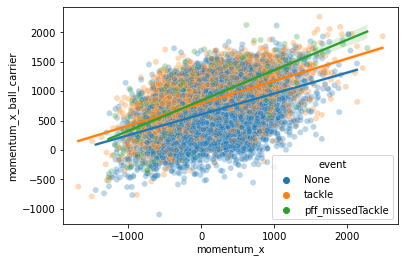

In [18]:
regression(run_metrics_df, 'momentum_x')

*why so many defenders are moving in same x direction as ball carrier*

--------------------

**lowess curves momentum_x vs momentum_x_ball_carrier**

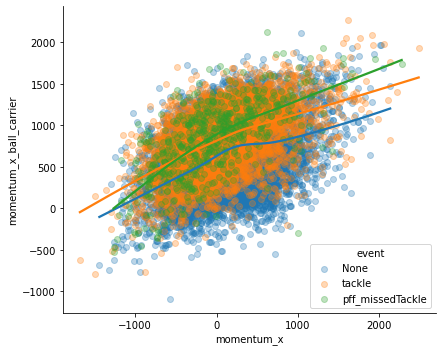

In [20]:
sns.lmplot(run_metrics_df, x="momentum_x", y="momentum_x_ball_carrier", lowess=True,
           hue='event', hue_order=run_metrics_df['event'].unique(), aspect=1.25,
           scatter_kws={'alpha': 0.3},
           facet_kws={'legend_out':False})

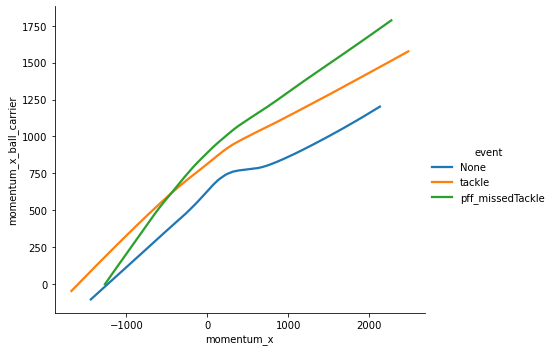

In [21]:
ax = sns.lmplot(run_metrics_df, x="momentum_x", y="momentum_x_ball_carrier", lowess=True,
           hue='event', hue_order=run_metrics_df['event'].unique(), aspect=1.25,
           scatter=False)

* separate analysis for momentum_x vs momentum_x_ball_carrier
    - plot x momentum when tackler moving in same direction as ball carrier
    - plot x momentum when tackler moving in opposite direction as ball carrier
    - what to do when momentum_x_ball_carrier is negative?
        * plot separately?
        * remove?
        * normalize both ball carrier and defender values?
       

**compare momentum_x between run and pass plays**

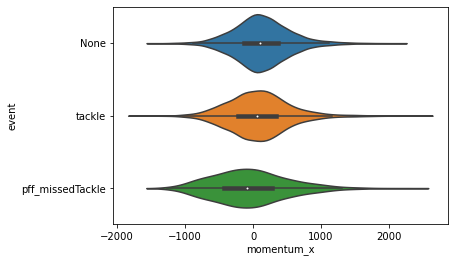

In [27]:
violin(run_metrics_df, 'momentum_x')

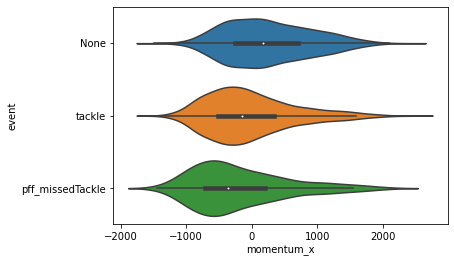

In [26]:
violin(pass_metrics_df, 'momentum_x')

**y direction**

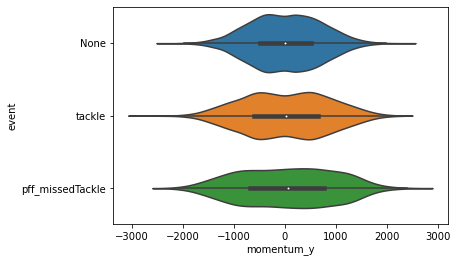

In [28]:
violin(run_metrics_df, 'momentum_y')

- missed tackles have a much flatter distribution
    * more tackles are missed (proportionally) when the tackler has lots of momentum in the y direction
        - can you say more tackles are missed when **MOST** of the tacklers momentum is moving in the y directions?
        

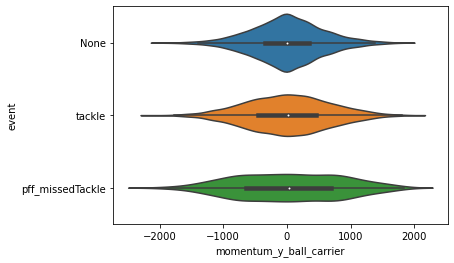

In [29]:
violin(run_metrics_df, 'momentum_y_ball_carrier')

* same applies to momentum_y_ball_carrier, but the plots look very different (dip at 0 momentum in defenders but not ball carriers) - what does this mean?

**momentum_y vs momentum_y_ball_carrier**

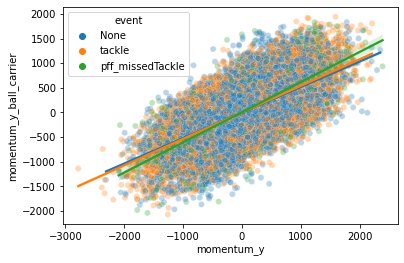

In [30]:
regression(run_metrics_df, 'momentum_y')

* momentum_y vs momentum_y_ball_carrier is highly correlated 
    - use this to lead into contact angle stats (plane of the ball carrier)

## momentum in the plane of the ball carrier
**contact_angle_momentum_y_abs**

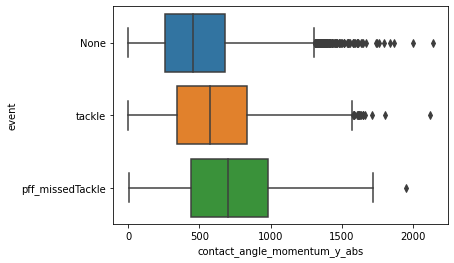

In [32]:
box(run_metrics_df, 'contact_angle_momentum_y_abs')

* proportionally more tackles are missed at higher momentums perpendicular to the direction of the ball carrier

    - plot contact_angle_momentum vs contact_angle_momentum_y_abs?